# NLP Application: Song Lyrics Classification

*Natural Language Processing (NLP)*

## Goal

Classify a song lyric to an artist.

In [1]:
import json

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, classification_report

## Load Data

In [4]:
json_files = [
    "data/lyrics_stevie_wonder.json"
    ,"data/lyrics_jamiroquai.json"
    #,"data/lyrics_zero_7.json"
    #,"data/lyrics_ray_charles.json"
    #,"data/lyrics_james_brown.json"
    #,"data/lyrics_creedence_clearwater_revival.json"
]

In [5]:
lyrics = []
for json_file in json_files:
    with open(json_file, encoding='ascii') as file:
        lyrics.extend(json.load(file))

In [6]:
#print(lyrics[0]['song_title'], '', lyrics[0]['lyrics'][:300]+'...', sep='\n')

In [7]:
df = pd.DataFrame(data=lyrics)
df.drop(['artist_searched'], axis=1, inplace=True)
df.head()

,artist_found,song_title,lyrics
0,Stevie Wonder,What Christmas Means to Me,Oh yeah\nCandles burnin' low\nLots of mistleto...
1,Stevie Wonder,The Christmas Song,Chestnuts roasting on an open fire\nJack Frost...
2,Stevie Wonder,Someday At Christmas,Someday at Christmas men won't be boys\nPlayin...
3,Stevie Wonder,We Can Work It Out,"Try to see it my way,\nDo I have to keep on ta..."
4,Stevie Wonder,Faith,See the girl with the diamonds and the shoes? ...


## Transform: Term Frequency-Inverse Document Frequency (TF-IDF)

In [8]:
corpus = df['lyrics']

# ignore words with numbers, thanks to https://stackoverflow.com/a/29375664
token_pattern = r"(?u)\b[^\d\W]{2,}\b"

vectorizer = TfidfVectorizer(token_pattern=token_pattern)
X = vectorizer.fit_transform(corpus)

In [9]:
vectorizer.get_feature_names()[:15]

['aa',
 'aaah',
 'aah',
 'aaow',
 'aaw',
 'abaout',
 'abbiam',
 'abc',
 'ability',
 'able',
 'about',
 'above',
 'absurdity',
 'abuse',
 'abused']

In [10]:
X[0].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [11]:
df_bow = pd.DataFrame(data=X.todense(), columns=vectorizer.get_feature_names())

In [12]:
df_bow.head()

,aa,aaah,aah,aaow,aaw,abaout,abbiam,abc,ability,able,...,your,yours,yourself,yourselves,yuletide,zero,zillion,zimbabwe,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018872,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027915,0.0,0.0,0.0,0.117588,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057732,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

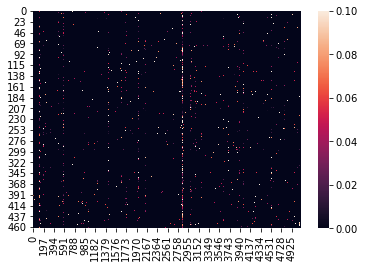

In [13]:
sns.heatmap(X.todense(), vmax=0.1)

In [14]:
assert len(df['artist_found'].unique()) == 2

## Train/Test split

Define X and y:

* X : Training data
* y : Target values

In [15]:
X = X
y = df['artist_found']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X.shape, X_train.shape, X_test.shape

((463, 5107), (347, 5107), (116, 5107))

## Modelling

### Logistic Regression

#### Train and evaluate

Class balancing using `class_weight='balanced'` was especially important here. Otherwise log reg predictet mostly one class for all!

In [17]:
m_logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
m_logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

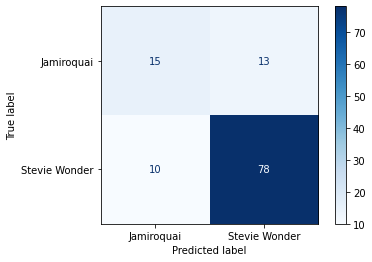

In [18]:
y_pred = m_logreg.predict(X_test)
plot_confusion_matrix(m_logreg, X_test, y_test, cmap='Blues')

In [19]:
print(classification_report(y_true=y_test, y_pred=y_pred))

               precision    recall  f1-score   support

   Jamiroquai       0.60      0.54      0.57        28
Stevie Wonder       0.86      0.89      0.87        88

     accuracy                           0.80       116
    macro avg       0.73      0.71      0.72       116
 weighted avg       0.80      0.80      0.80       116



#### Phrase classification

In [20]:
test_phrase_stevie = "Just don't you feel too bad" # Stevie Wonder (Don't You Worry 'bout a Thing)
v_phrase_stevie = vectorizer.transform([test_phrase_stevie])

In [21]:
df_phrase = pd.DataFrame(data=v_phrase_stevie.todense(), columns=vectorizer.get_feature_names())
df_phrase.loc[:, df_phrase.gt(0).all()] # show only columns with values greater than

,bad,don,feel,just,too,you
0,0.618667,0.322437,0.435079,0.307195,0.433551,0.204098


In [22]:
m_logreg.predict(v_phrase_stevie)[0]

'Stevie Wonder'

### Naive Bayes Classifier

Note that this is without any class balancing techniques.

In [23]:
param_grid = dict(alpha=np.linspace(0.00001,1,50))
m_bayes = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, scoring='f1_weighted')
m_bayes.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': array([1.00000000e-05, 2.04179592e-02, 4.08259184e-02, 6.12338776e-02,
       8.16418367e-02, 1.02049796e-01, 1.22457755e-01, 1.42865714e-01,
       1.63273673e-01, 1.83681633e-01, 2.04089592e-01, 2.24497551e-01,
       2.44905510e-01, 2.65313469e-01, 2.85721429e-01, 3.06129388e-01,
       3.26537347e-01, 3.46945306e-01, 3.67353265e-01...
       5.71432857e-01, 5.91840816e-01, 6.12248776e-01, 6.32656735e-01,
       6.53064694e-01, 6.73472653e-01, 6.93880612e-01, 7.14288571e-01,
       7.34696531e-01, 7.55104490e-01, 7.75512449e-01, 7.95920408e-01,
       8.16328367e-01, 8.36736327e-01, 8.57144286e-01, 8.77552245e-01,
       8.97960204e-01, 9.18368163e-01, 9.38776122e-01, 9.59184082e-01,
       9.79592041e-01, 1.00000000e+00])},
             scoring='f1_weighted')

In [24]:
m_bayes.best_params_

{'alpha': 0.020417959183673468}

In [25]:
m_bayes.cv_results_['mean_test_score'][m_bayes.best_index_], m_bayes.cv_results_['std_test_score'][m_bayes.best_index_]

(0.8240018476083023, 0.059522303802718744)

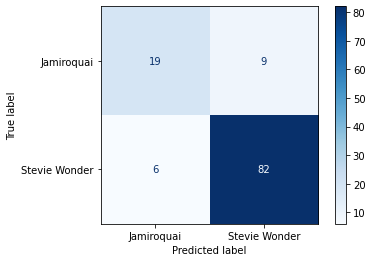

In [26]:
y_pred = m_bayes.predict(X_test)
plot_confusion_matrix(m_bayes, X_test, y_test, cmap='Blues')

In [27]:
print(classification_report(y_true=y_test, y_pred=y_pred))

               precision    recall  f1-score   support

   Jamiroquai       0.76      0.68      0.72        28
Stevie Wonder       0.90      0.93      0.92        88

     accuracy                           0.87       116
    macro avg       0.83      0.81      0.82       116
 weighted avg       0.87      0.87      0.87       116



In [28]:
m_bayes.predict(v_phrase_stevie)[0], m_bayes.predict_proba(v_phrase_stevie)

('Stevie Wonder', array([[0.25573919, 0.74426081]]))